In [1]:
# imports
import io
import json
import os
from pathlib import Path

# packages
import pandas
import matplotlib.pyplot as plt
from IPython.display import display, display_html


# project imports
from question_data import parse_question_source

In [2]:
# load the questions
question_list = parse_question_source(
    Path(os.getcwd()).parent / "data" / "questions_02.txt"
)

# load the exam result data
exam_df = pandas.read_csv(
    Path(os.getcwd()).parent
    / "results"
    / "questions-02"
    / "sessions-001"
    / "exam_results.csv",
    low_memory=False,
)
old_exam_df = pandas.read_csv(
    Path(os.getcwd()).parent
    / "results"
    / "questions-02"
    / "sessions-002"
    / "exam_results.csv",
    low_memory=False,
)

# calculate the baseline multiple choice rate by averaging 1/N, N=len(choices)
multiple_choice_counts = []
for question in question_list:
    if question["question_type"] == "multiple_choice":
        multiple_choice_counts.append(len(question["choices"]))

# print key stats on counts
print(f"Questions: {len(question_list)}\n")

print(f"Exam Data: {exam_df.shape}\n")

Questions: 208

Exam Data: (37440, 23)



In [3]:
# get the random chance rate by average 1/N from the list
random_chance_rate = sum([1 / float(c) for c in multiple_choice_counts]) / len(
    multiple_choice_counts
)
print(f"Multiple Choice Random Chance Rate: {100*random_chance_rate:.2f}%")

Multiple Choice Random Chance Rate: 25.00%


In [4]:
# number of exams
print("Exam Sessions:", exam_df["session_name"].nunique())

Exam Sessions: 180


In [5]:
# number of prompts
print("Number of Prompts:", exam_df["prompt_method"].nunique())

Number of Prompts: 10


In [6]:
# print headline accuracy rate
accuracy_rate = exam_df["is_correct"].mean()
print(f"Headline Accuracy Rate: {accuracy_rate:.2%}")

Headline Accuracy Rate: 55.06%


In [7]:
# old exam headline rates
old_accuracy_rate_by_model = old_exam_df.groupby(["model_name"])["is_correct"].mean()
display(pandas.DataFrame(old_accuracy_rate_by_model))

,is_correct
model_name,
text-ada-001,0.097356
text-babbage-001,0.252404
text-curie-001,0.204327
text-davinci-001,0.299279


<AxesSubplot: xlabel='model_name'>

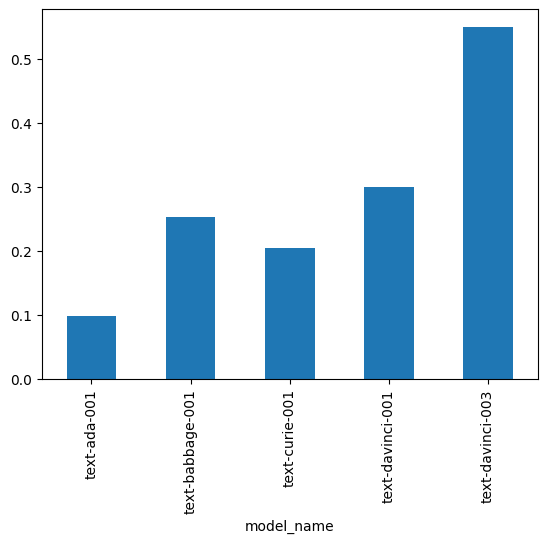

In [8]:
# combine new and old models
all_exam_df = pandas.concat([exam_df, old_exam_df], axis=0)
accuracy_by_model = all_exam_df.groupby(["model_name"])["is_correct"].mean()
accuracy_by_model.plot(kind="bar")

In [9]:
# print per-question type accuracy rate
print(f"Per-Question Type Accuracy Rate:")
per_qt_accuracy_rate = exam_df.groupby("question_type")["is_correct"].mean()
display(pandas.DataFrame(per_qt_accuracy_rate))

per_qt_top2_accuracy_rate = exam_df.groupby("question_type")[
    "is_top_two_correct"
].mean()
display(pandas.DataFrame(per_qt_top2_accuracy_rate))

Per-Question Type Accuracy Rate:


,is_correct
question_type,
multiple_choice,0.550561


,is_top_two_correct
question_type,
multiple_choice,0.767067


In [10]:
# print per-prompt accuracy rate
print(f"Per-Prompt Accuracy Rate:")
per_prompt_accuracy_rate = exam_df.groupby("prompt_method")["is_correct"].mean()
display(
    pandas.DataFrame(per_prompt_accuracy_rate).sort_values(
        "is_correct", ascending=False
    )
)

Per-Prompt Accuracy Rate:


,is_correct
prompt_method,
generate_prompt_013,0.569177
generate_prompt_011,0.564103
generate_prompt_018,0.557692
generate_prompt_015,0.556357
generate_prompt_012,0.556090
generate_prompt_020,0.553686
generate_prompt_019,0.549145
generate_prompt_014,0.548344
generate_prompt_017,0.540331


In [19]:
per_prompt_accuracy_rate.describe()

count    10.000000
mean      0.550561
std       0.016181
min       0.510684
25%       0.548544
50%       0.554888
75%       0.557358
max       0.569177
Name: is_correct, dtype: float64

In [11]:
# print per-prompt accuracy rate
print(f"Per-Prompt Accuracy Rate:")
per_prompt_top2_accuracy_rate = exam_df.groupby("prompt_method")[
    "is_top_two_correct"
].mean()
display(pandas.DataFrame(per_prompt_top2_accuracy_rate))

Per-Prompt Accuracy Rate:


,is_top_two_correct
prompt_method,
generate_prompt_011,0.807692
generate_prompt_012,0.803686
generate_prompt_013,0.817575
generate_prompt_014,0.793536
generate_prompt_015,0.793002
generate_prompt_016,0.721688
generate_prompt_017,0.722222
generate_prompt_018,0.721955
generate_prompt_019,0.722756


In [12]:
exam_df.groupby(["session_name", "question_section"])[
    "is_correct"
].count().unstack().mean()

question_section
AUD    54.0
BEC    50.0
FAR    51.0
REG    53.0
dtype: float64

In [13]:
prompt_qt_accuracy_rate = (
    exam_df.groupby(["prompt_method", "question_section"])["is_correct"]
    .mean()
    .unstack()
)
display(prompt_qt_accuracy_rate)

question_section,AUD,BEC,FAR,REG
prompt_method,,,,
generate_prompt_011,0.524691,0.652222,0.520697,0.562893
generate_prompt_012,0.555556,0.672222,0.485839,0.514675
generate_prompt_013,0.565844,0.690000,0.494553,0.530398
generate_prompt_014,0.551440,0.662222,0.477124,0.506289
generate_prompt_015,0.570988,0.657778,0.481481,0.517820
generate_prompt_016,0.466049,0.610000,0.531590,0.442348
generate_prompt_017,0.516461,0.625556,0.509804,0.513627
generate_prompt_018,0.576132,0.658889,0.484749,0.513627
generate_prompt_019,0.519547,0.631111,0.533769,0.516771


In [14]:
prompt_qt_accuracy_rate = (
    exam_df.groupby(["prompt_method", "question_section"])["is_top_two_correct"]
    .mean()
    .unstack()
)
prompt_qt_accuracy_rate["Overall"] = exam_df.groupby(["prompt_method"])[
    "is_top_two_correct"
].mean()
display(prompt_qt_accuracy_rate.sort_values("AUD", ascending=False))

question_section,AUD,BEC,FAR,REG,Overall
prompt_method,,,,,
generate_prompt_013,0.847737,0.854444,0.807190,0.762055,0.817575
generate_prompt_012,0.836420,0.857778,0.770153,0.751572,0.803686
generate_prompt_015,0.831276,0.825556,0.752723,0.762055,0.793002
generate_prompt_014,0.817901,0.814444,0.795207,0.747379,0.793536
generate_prompt_011,0.810700,0.841111,0.814815,0.766247,0.807692
generate_prompt_016,0.737654,0.731111,0.757081,0.662474,0.721688
generate_prompt_020,0.724280,0.820000,0.770153,0.755765,0.766560
generate_prompt_018,0.720165,0.810000,0.674292,0.686583,0.721955
generate_prompt_017,0.704733,0.805556,0.688453,0.693920,0.722222


In [15]:
exam_df.groupby("question_section")["question_number"].nunique()

question_section
AUD    54
BEC    50
FAR    51
REG    53
Name: question_number, dtype: int64

In [16]:
temperature_best_of_accuracy_rate = (
    exam_df.groupby(["temperature", "best_of"])["is_correct"].mean().unstack()
)
display(temperature_best_of_accuracy_rate)

best_of,1,2
temperature,,
0.0,0.553045,0.550962
0.5,0.550962,0.551122
1.0,0.548397,0.548878


In [17]:
prompt_temperature_accuracy_rate = (
    exam_df.groupby(["prompt_method", "temperature"])["session_name"]
    .nunique()
    .unstack()
)
display(prompt_temperature_accuracy_rate)

temperature,0.0,0.5,1.0
prompt_method,,,
generate_prompt_011,6,6,6
generate_prompt_012,6,6,6
generate_prompt_013,6,6,6
generate_prompt_014,6,6,6
generate_prompt_015,6,6,6
generate_prompt_016,6,6,6
generate_prompt_017,6,6,6
generate_prompt_018,6,6,6
generate_prompt_019,6,6,6


In [18]:
# compare only the multiple choice questions against the baseline rate
mc_exam_df = exam_df.loc[exam_df["question_type"] == "multiple_choice", :]

prompt_temp_mc_accuracy = (
    mc_exam_df.groupby(["prompt_method", "temperature"])["is_correct"].mean().unstack()
)
prompt_temp_mc_accuracy_sem = (
    mc_exam_df.groupby(["prompt_method", "temperature"])["is_correct"].sem().unstack()
)
prompt_temp_mc_accuracy_spread = prompt_temp_mc_accuracy - random_chance_rate

prompt_temp_mc_low_ci_spread = (
    prompt_temp_mc_accuracy_spread - prompt_temp_mc_accuracy_sem
)
display(prompt_temp_mc_accuracy_spread)
display(prompt_temp_mc_low_ci_spread > 0)

temperature,0.0,0.5,1.0
prompt_method,,,
generate_prompt_011,0.317308,0.313301,0.311699
generate_prompt_012,0.302885,0.305288,0.310096
generate_prompt_013,0.326122,0.314904,0.316506
generate_prompt_014,0.292468,0.300481,0.302083
generate_prompt_015,0.313301,0.306090,0.299679
generate_prompt_016,0.261218,0.270032,0.250801
generate_prompt_017,0.296474,0.290064,0.284455
generate_prompt_018,0.305288,0.310897,0.306891
generate_prompt_019,0.303686,0.297276,0.296474


temperature,0.0,0.5,1.0
prompt_method,,,
generate_prompt_011,True,True,True
generate_prompt_012,True,True,True
generate_prompt_013,True,True,True
generate_prompt_014,True,True,True
generate_prompt_015,True,True,True
generate_prompt_016,True,True,True
generate_prompt_017,True,True,True
generate_prompt_018,True,True,True
generate_prompt_019,True,True,True
